<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/effB2_FoodViz_tinkering_v003_effB2_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TL;DR ###

- I applied another version of eff -> EfficientNet_B2 to our same model, with minor tweaks to support this version of the EfficientNet pre-trained model, with the expectation, test accuracy would have some minor improvements, which did occur.

- *However* ... - when looking at the probabilities in the labels, the B0 probabilities performed *much* better on correct labeling - e.g., the correct labels had higher probabilities assigned to the correct label (and B0 got ALL correct on the unseen random images, whereas B2 incorrectly labeled one...) Hence, it could be argued that B0 - all things being equal - in addition to performing better, on labels in which it classified the same as B2, B0 was *more* correct.



In [41]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer as timer
from tqdm import tqdm

import requests
import zipfile
from pathlib import Path
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [42]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

print(device)

mps


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Load the data from the drive:

train_dir = "./data/pizza_steak_sushi/train/"
test_dir = "./data/pizza_steak_sushi/test/"

### EfficientNet_B2 ###

In [44]:
# Load EfficientNet with B2 pretrained weights

# weights_eff = models.EfficientNet_B0_Weights.IMAGENET1K_V1

weights_eff = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model_eff = models.efficientnet_b2(weights=weights_eff)
preprocess_eff = weights_eff.transforms()

In [45]:
# Use the preprocess transform for EfficientNet_B0 (preprocess_eff)

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess_eff
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess_eff
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=2
)

In [46]:
test_dataset.classes

['pizza', 'steak', 'sushi']

In [47]:
# EfficientNet_B2 model, class, device, criterion & optimizer instantiation

model = model_eff

# Number of classes (Pizza–Steak–Sushi)
num_classes = len(train_dataset.classes)  # should be 3

# Freeze all layers except classifier head
for param in model.parameters():
    param.requires_grad = False

# Replace the final classifier
# EfficientNet_B2 has model.classifier = Sequential(Dropout, Linear)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Move model to device
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

In [ ]:
# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

# Lists to store metrics over epochs
train_losses = []
train_accuracies = []

# Since we already know it works well, just going with 20 epochs;)
epochs = 24

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    # Compute metrics for this epoch
    train_loss = running_loss / total
    train_acc = correct / total * 100
    
    # lr scheduler
    scheduler.step()

    # Save metrics (so we can plot a loss/acc curve!)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}%")

  4%|█▉                                            | 1/24 [00:18<07:01, 18.33s/it]

Epoch 1/24 | Loss: 1.0210 | Acc: 49.7778%


  8%|███▊                                          | 2/24 [00:33<06:07, 16.69s/it]

Epoch 2/24 | Loss: 0.8286 | Acc: 71.1111%


 12%|█████▊                                        | 3/24 [00:48<05:31, 15.78s/it]

Epoch 3/24 | Loss: 0.7060 | Acc: 83.1111%


 17%|███████▋                                      | 4/24 [01:03<05:09, 15.49s/it]

Epoch 4/24 | Loss: 0.5949 | Acc: 87.5556%


 21%|█████████▌                                    | 5/24 [01:18<04:49, 15.22s/it]

Epoch 5/24 | Loss: 0.5319 | Acc: 90.2222%


 25%|███████████▌                                  | 6/24 [01:33<04:31, 15.08s/it]

Epoch 6/24 | Loss: 0.4906 | Acc: 92.4444%


 29%|█████████████▍                                | 7/24 [01:47<04:13, 14.90s/it]

Epoch 7/24 | Loss: 0.4534 | Acc: 91.1111%


 33%|███████████████▎                              | 8/24 [02:02<03:57, 14.84s/it]

Epoch 8/24 | Loss: 0.4296 | Acc: 93.7778%


 38%|█████████████████▎                            | 9/24 [02:16<03:40, 14.71s/it]

Epoch 9/24 | Loss: 0.4157 | Acc: 93.3333%


 42%|██████████████████▊                          | 10/24 [02:31<03:25, 14.71s/it]

Epoch 10/24 | Loss: 0.3783 | Acc: 94.6667%


 46%|████████████████████▋                        | 11/24 [02:47<03:15, 15.01s/it]

Epoch 11/24 | Loss: 0.4037 | Acc: 91.1111%


 50%|██████████████████████▌                      | 12/24 [03:02<03:00, 15.05s/it]

Epoch 12/24 | Loss: 0.3590 | Acc: 94.6667%


 54%|████████████████████████▍                    | 13/24 [03:18<02:47, 15.24s/it]

Epoch 13/24 | Loss: 0.3477 | Acc: 94.6667%


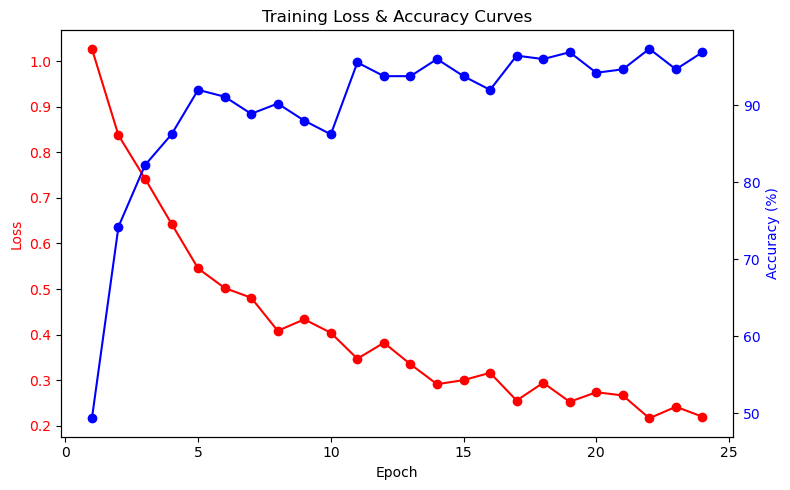

In [10]:
# --------------------------
# Plot Loss & Accuracy
# --------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot loss on left y-axis
ax1.plot(range(1, epochs+1), train_losses, color='red', marker='o', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), train_accuracies, color='blue', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title('Training Loss & Accuracy Curves')
fig.tight_layout()
plt.show();

In [11]:
# Running Test Loop on EfficientNet

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.4f}%")

Test Accuracy: 89.3333%


In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [13]:
train_loss, train_acc

(0.21992775069342718, 96.88888888888889)

In [39]:
datetime.now().strftime("%Y%m%d"), datetime.now().strftime("%Y%m%d_%H%M"), datetime.now().strftime("%Y%m%d--%H%ML"), datetime.now().strftime("%Y-%m-%d"), datetime.now().strftime("%Y-%m-%d__%H%ML")

('20251024',
 '20251024_1533',
 '20251024--1533L',
 '2025-10-24',
 '2025-10-24__1533L')

***Save trained model***

In [14]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)  # creates it if it doesn't exist

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")
model_save_path = os.path.join(save_dir, f"efficientnet_b2_pizza_steak_sushi_{current_date}.pth")

In [15]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_pizza_steak_sushi_20251022.pth


In [16]:
import os
from PIL import Image
import torch
from torchvision import models

# Folder containing unseen images
folder_path = "./data/unseen_pza_stk_ssh/"

# Make a list of image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Preprocessing used for EfficientNet_B0
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Class names (same as your dataset)
class_names = ["pizza", "steak", "sushi"]

# Ensure the model is in evaluation mode
model.eval()
model = model.to(device)

In [17]:
predicted_labels = []
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = class_names[probabilities.argmax()]
        predicted_labels.append(predicted_class)

    print(f"{img_name} → Predicted: {predicted_class}")

sushi_003.jpeg → Predicted: sushi
sushi_002.jpeg → Predicted: sushi
pizza_001.jpeg → Predicted: pizza
steak_001.jpeg → Predicted: pizza
steak_003.jpeg → Predicted: steak
steak_002.jpeg → Predicted: steak
sushi_001.jpeg → Predicted: sushi
pizza_002.jpeg → Predicted: pizza
pizza_003.jpeg → Predicted: pizza


In [18]:
# Extract true labels from filenames
true_labels = [f.split("_")[0] for f in image_files]
print(true_labels)

['sushi', 'sushi', 'pizza', 'steak', 'steak', 'steak', 'sushi', 'pizza', 'pizza']


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:

              precision    recall  f1-score   support

       pizza       0.75      1.00      0.86         3
       steak       1.00      0.67      0.80         3
       sushi       1.00      1.00      1.00         3

    accuracy                           0.89         9
   macro avg       0.92      0.89      0.89         9
weighted avg       0.92      0.89      0.89         9

Confusion Matrix:

[[3 0 0]
 [1 2 0]
 [0 0 3]]


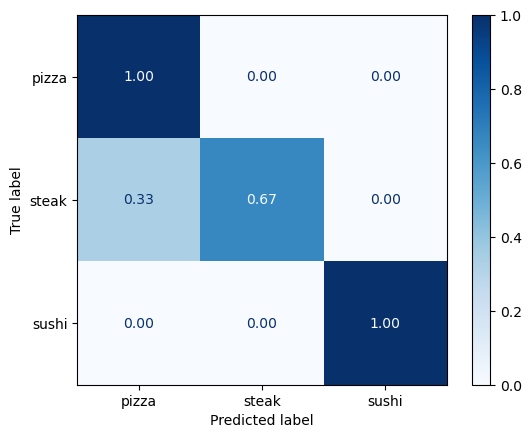

In [20]:
# ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels
    , normalize="true", cmap="Blues"
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.show();

In [22]:
import os
from PIL import Image
import torch
from torchvision import models
from matplotlib import pyplot as plt

In [23]:
# Updated predix function w/ probabilities displayed;

def show_image_prediction(img_path):
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = probabilities.argmax()
        pred_class = class_names[pred_idx]
        pred_prob = probabilities[pred_idx].item() * 100

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({pred_prob:.2f}%)", fontsize=14, color='green')
    plt.show()

    # Print probability distribution below the image
    print("Class probabilities:")
    for i, cls in enumerate(class_names):
        prob = probabilities[i].item() * 100
        mark = "True" if i == pred_idx else "False"
        print(f"{mark} {cls:10s}: {prob:.4f}%")

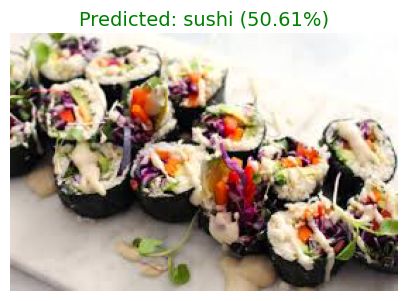

Class probabilities:
False pizza     : 28.8136%
False steak     : 20.5788%
True sushi     : 50.6076%


In [24]:
show_image_prediction(os.path.join(folder_path, image_files[0]))

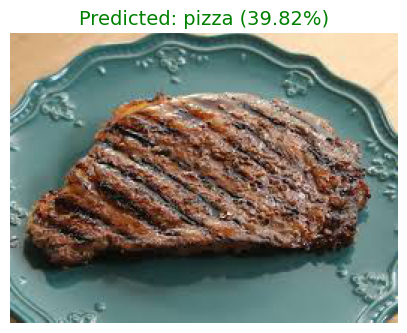

Class probabilities:
True pizza     : 39.8208%
False steak     : 35.5800%
False sushi     : 24.5992%


In [25]:
show_image_prediction(os.path.join(folder_path, image_files[3]))

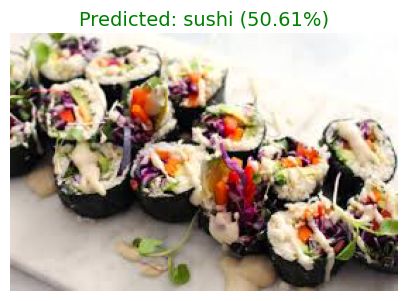

Class probabilities:
False pizza     : 28.8136%
False steak     : 20.5788%
True sushi     : 50.6076%


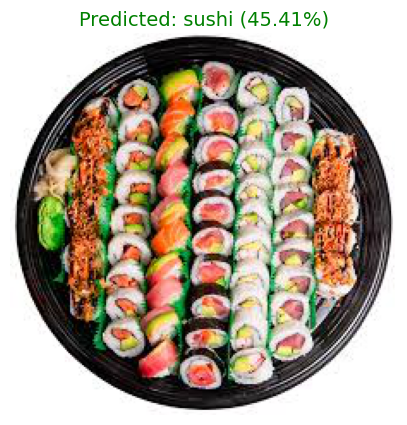

Class probabilities:
False pizza     : 31.9935%
False steak     : 22.5948%
True sushi     : 45.4117%


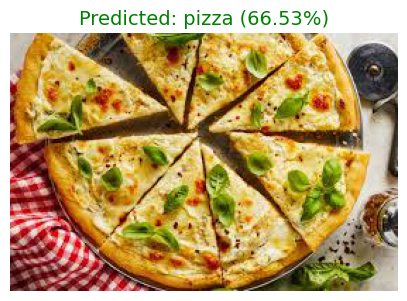

Class probabilities:
True pizza     : 66.5294%
False steak     : 13.8315%
False sushi     : 19.6391%


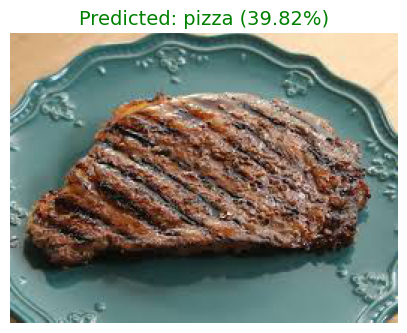

Class probabilities:
True pizza     : 39.8208%
False steak     : 35.5800%
False sushi     : 24.5992%


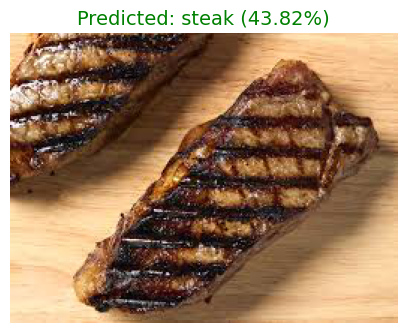

Class probabilities:
False pizza     : 27.9204%
True steak     : 43.8185%
False sushi     : 28.2611%


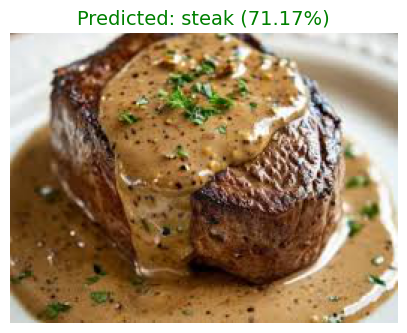

Class probabilities:
False pizza     : 21.7342%
True steak     : 71.1745%
False sushi     : 7.0913%


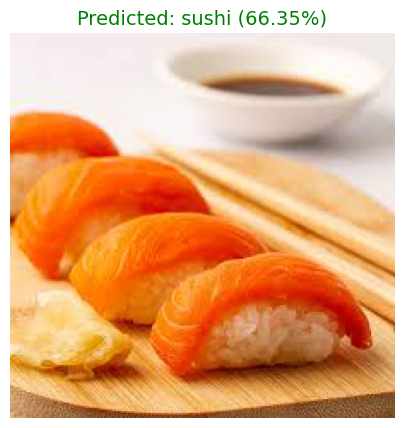

Class probabilities:
False pizza     : 15.5986%
False steak     : 18.0564%
True sushi     : 66.3450%


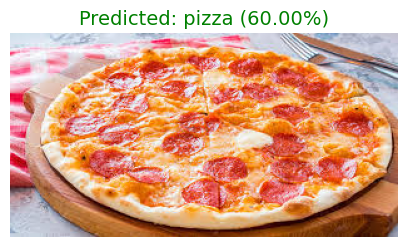

Class probabilities:
True pizza     : 60.0016%
False steak     : 16.0598%
False sushi     : 23.9385%


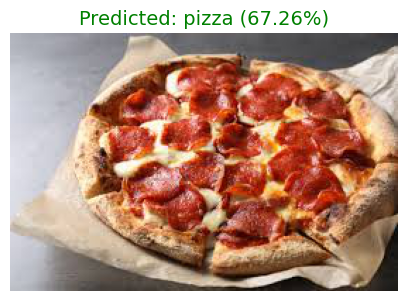

Class probabilities:
True pizza     : 67.2605%
False steak     : 16.8566%
False sushi     : 15.8830%


In [26]:
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    show_image_prediction(img_path)

In [27]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [32]:
images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 25
single image shape: torch.Size([3, 288, 288])
single label: 2


In [33]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 0


### Observations ###

- In comparing EfficientNetB2 vs EfficientNetB0 performance, the B2 was only fractionally better in test data - BUT - when looking at the probabilities in the labels, the B0 probabilities were much better on correct labeling (hence, it could be argued that B0 - all things being equal - was *more* correct.)